<a href="https://colab.research.google.com/github/joyjixu/game_theory/blob/main/game_theory_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BASC00017 Interdisciplinary Game Theory Assignment 1
# Code appendix
by Joy Xu

---


First we install the necessary Python libraries and update dependencies:

In [1]:
! pip install nashpy
! pip install axelrod

! pip install -U PyYAML

  Created wheel for nashpy: filename=nashpy-0.0.19-cp36-none-any.whl size=10814 sha256=27989356a035be0cedb296f7d2412126395f17b06a6c0050aaf6decc2124f876
  Stored in directory: /root/.cache/pip/wheels/18/e9/56/2d04d01a6969d167f86d3afcb3d128c0b43d0d73ea471c835b
Successfully built nashpy
     |████████████████████████████████| 194kB 5.7MB/s 
     |████████████████████████████████| 368kB 32.9MB/s 
     |████████████████████████████████| 102kB 9.0MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.16 which is incompatible.
ERROR: ipython 5.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.4, but you'll have prompt-toolkit 3.0.16 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18


     |████████████████████████████████| 645kB 5.6MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Then we can import the libraries we need into the notebook.

In [2]:
import nashpy as nash
import numpy as np
import matplotlib.pyplot as plt
import axelrod as axl
from axelrod import Game
from typing import Tuple, Union
from axelrod import Action
from statistics import mean



In [3]:
import yaml
yaml.__version__

'5.4.1'

# 1. Checking MSNE using Nashpy
Although the MSNE was calculated manually in the assignment, we can verify that is is correct using Nashpy. Below we create a game with player A and B, and set the payoffs.

In [4]:
A = np.array([[3,0],[1,1]]) # A is the row player
B = np.array([[2,1],[0,1]]) # B is the column player
game1 = nash.Game(A,B)
game1

Bi matrix game with payoff matrices:

Row player:
[[3 0]
 [1 1]]

Column player:
[[2 1]
 [0 1]]

Then we can calculate any equilibria.

In [5]:
# Player A has strategies (Top, Bottom) and Player B has strategies (Left, Right)
equilibria = game1.support_enumeration()
for eq in equilibria:
    print(eq)

(array([1., 0.]), array([1., 0.]))
(array([0., 1.]), array([0., 1.]))
(array([0.5, 0.5]), array([0.33333333, 0.66666667]))


The cell above prints out three equilibria. The first two are the Pure strategy NE and the last one is the MSNE. We can read each line as (player1 action ([prob top strategy, prob bottom strategy]), player 2 action([prob left strategy, prob right strategy])).

* top: cooperate
* bottom : defect
* left: cooperate
* right: defect

*Results:*

(array(1., 0.), array(1., 0.)) ---> top left: both cooperate

(array(0., 1.), array(0., 1.)) ---> bottom right: both defect

(array(0.5, 0.5), array(0.33, 0.67)) ---> Mixed strategy: Player 1 (UK) plays cooperate with probability 0.5, Player 2 (China) plays cooperate with probability 0.33

____________________________________________________________________________________________________

# Iterating with Axelrod
* Axelrod is another Python library we can use for iterating the stag hunt
* The library was designed for the iterated Prsinoner's dilemma, so we have to change some code to allow for asymmetric payoffs
* We do that by creating a new class that inherits from the Game class (what we would have used normally for a PD)

In [6]:
C, D = Action.C, Action.D
class AsymmetricGame(Game):
    Score = Union[int, float]
    # the line below adds r2, p2, s2, t2 as parameters for the Game class (otherwise both players would have the same RPST payoffs)
    def __init__(self, r: Score = 3, s: Score = 0, t: Score = 5, p: Score = 1, r2: Score = 3, s2: Score = 0, t2: Score = 5, p2: Score = 1) -> None:
        """Create a new game object.
        
        Parameters
        ----------
        r: int or float
            Score obtained by both players for mutual cooperation.
        s: int or float
            Score obtained by a player for cooperating against a defector.
        t: int or float
            Score obtained by a player for defecting against a cooperator.
        p: int or float
            Score obtained by both player for mutual defection.
        """
        self.scores = {(C, C): (r, r2), (D, D): (p, p2), (C, D): (s, t2), (D, C): (t, s2)}


    def RPST(self) -> Tuple[Score, Score, Score, Score]:
        """Returns game matrix values in Press and Dyson notation."""
        R = self.scores[(C, C)]
        P = self.scores[(D, D)]
        S = self.scores[(C, D)]
        T = self.scores[(D, C)]
        return R, P, S, T

Next we also add a strategy wrapper to customize the player's strategy for our MSNE. In the assignment we mentioned that China would play the first round using MSNE, so the strategy wrapper will alter any strategy (e.g. tit-for-tat) so that the first round will be played with MSNE.

We also create a strategy wrapper for the UK's MSNE.

In [7]:
# the UK's probability p of cooperate is 0.5 so the parameter prob is set to 0.5
def strategy_wrapper_uk(player, opponent, proposed_action, prob=0.5,*args, **kwargs):
    """
    Strategy wrapper functions should be of the following form.

    Parameters
    ----------
    player: Player object or subclass (self)
    opponent: Player object or subclass
    proposed_action: an axelrod.Action, C or D
        The proposed action by the wrapped strategy
        proposed_action = Player.strategy(...)
    args, kwargs:
        Any additional arguments that you need.

    Returns
    -------
    action: an axelrod.Action, C or D

    """
    if len(player.history) == 0:
        random = np.random.rand()
        if random < prob:
            return C
        return D        
    return proposed_action

In [8]:
# China's probability p of cooperate is 0.33 so the parameter prob is set to 0.33

def strategy_wrapper_china(player, opponent, proposed_action, prob=0.33,*args, **kwargs):
    """
    Strategy wrapper functions should be of the following form.

    Parameters
    ----------
    player: Player object or subclass (self)
    opponent: Player object or subclass
    proposed_action: an axelrod.Action, C or D
        The proposed action by the wrapped strategy
        proposed_action = Player.strategy(...)
    args, kwargs:
        Any additional arguments that you need.

    Returns
    -------
    action: an axelrod.Action, C or D

    """
    if len(player.history) == 0:
        random = np.random.rand()
        if random < prob:
            return C
        return D        
    return proposed_action

_____________________________________________________________________

# Define the game

* We can now create our game and set the utilities for each strategy profile

In [9]:
# creating the game
foreign_policy = AsymmetricGame(r=3, p=1, s=0, t=1,r2=2, p2=1, s2=0, t2=1)
print("Utilities: (C,c), (D,d), (C,d), (D,c): ", foreign_policy.RPST())


Utilities: (C,c), (D,d), (C,d), (D,c):  ((3, 2), (1, 1), (0, 1), (1, 0))


# Define players
* Axelrod already has some pre-existing strategies that we can import
* We can transform those strategies to tailor them according to our MSNE

In [10]:
from axelrod.strategy_transformers import *

In [11]:
# transformed strategies (each strategy is a class)
# we need to make a new class for each transformed strategy

TransformedClassUK = StrategyTransformerFactory(strategy_wrapper_uk, name_prefix="UK")() 

TransformedClassChina = StrategyTransformerFactory(strategy_wrapper_china, name_prefix="China")() 

# modifying the tit-for-tat strategy
china_msne_tft = TransformedClassChina(axl.TitForTat) # will cooperate with probability 0.5 in first round only, then tit-for-tat
uk_msne_tft = TransformedClassUK(axl.TitForTat) # will cooperate with probability 0.33 in first round only, then tit-for-tat

In [12]:
# other UK strategies (see table in assignment)

# MSNE
uk_msne = axl.Random(p=0.5)

# C-TFT
uk_coop_tft = axl.TitForTat()

# D-TFT
uk_def_tft = InitialTransformer([D])(axl.TitForTat)()

#C
uk_coop = axl.Cooperator()

#D
uk_def = axl.Defector()

---
# Playing the game

In [13]:
# test run: 50 rounds using our defined payoffs
# UK always playes using MSNE, China plays with MSNE on first round then tit-for-tat

players = [uk_msne, china_msne_tft()]

match = axl.Match(players, 50, game=foreign_policy)
match.play()
match.scores()

[(0, 1),
 (1, 0),
 (0, 1),
 (3, 2),
 (3, 2),
 (3, 2),
 (1, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 1),
 (3, 2),
 (3, 2),
 (3, 2),
 (1, 0),
 (0, 1),
 (1, 0),
 (0, 1),
 (3, 2),
 (3, 2),
 (1, 0),
 (1, 1),
 (0, 1),
 (3, 2),
 (3, 2),
 (1, 0),
 (1, 1),
 (1, 1),
 (0, 1),
 (3, 2),
 (1, 0),
 (0, 1),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (1, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 1)]

Above we can see the scores for each player (UK, China) for each round

Now we start comparing the UK strategies

* each game will have 100 rounds, and the final score is the sum of the scores of each round
* we then take the average of the final score for 100 repeated games to account for variability


In [14]:
# making a function to iterate the game
from statistics import mean

def iterate(n_rounds, players, noise=0.2):
  avg_self_coops = []
  avg_opp_coops = []
  avg_self_final_scores = []
  avg_opponent_final_scores = []

  for i in range(1,n_rounds+1):
      self_coops = []
      opp_coops = []
      self_final_scores = []
      opponent_final_scores = []
      winner = []
      for j in range(1,101):
          
          match = axl.Match(players, i, game=foreign_policy, noise=noise)
          match.play()
          self_final_scores.append(match.final_score()[0])
          opponent_final_scores.append(match.final_score()[1])
          self_coops.append(match.cooperation()[0])
          opp_coops.append(match.cooperation()[1])

      #finding the averages for 100 games
      avg_self_final_scores.append(mean(self_final_scores))
      avg_opponent_final_scores.append(mean(opponent_final_scores))
      avg_self_coops.append(mean(self_coops))
      avg_opp_coops.append(mean(opp_coops))

  return avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores

In [15]:
# making a function to print stats
def stats(n_rounds, avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores):
  x=[x for x in range(1,51)]

  plt.figure(figsize=(20,5))
  plt.plot(x, avg_self_final_scores, label = "UK final utility")
  plt.plot(x, avg_opponent_final_scores, label = "China final utility")

  plt.xlabel("Number of rounds in game")
  plt.ylabel("Average final utility (100 games)")
  plt.legend()
  plt.show()

  # print stats
  for i in range(0,n_rounds):
      print((i+1), "avg # coops", avg_self_coops[i], avg_opp_coops[i], "avg final scores self, opp: ", avg_self_final_scores[i], avg_opponent_final_scores[i])

## UK plays MSNE

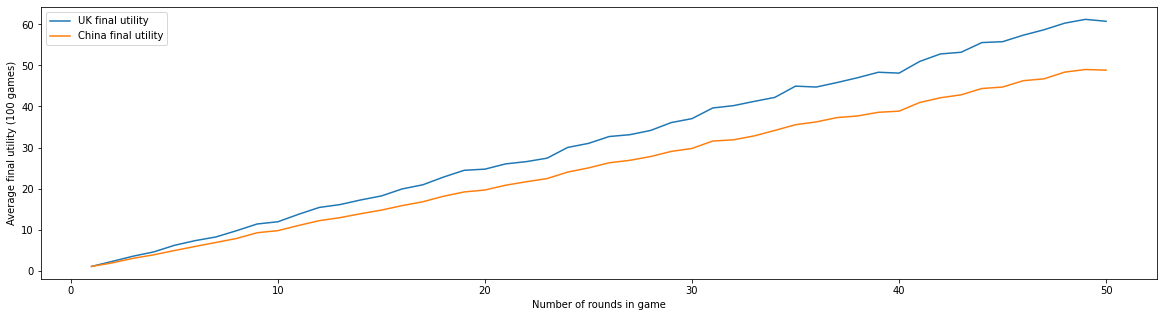

1 avg # coops 0.48 0.31 avg final scores self, opp:  1.06 1.05
2 avg # coops 0.95 0.9 avg final scores self, opp:  2.28 1.92
3 avg # coops 1.41 1.28 avg final scores self, opp:  3.54 3.02
4 avg # coops 1.88 1.76 avg final scores self, opp:  4.58 3.88
5 avg # coops 2.47 2.52 avg final scores self, opp:  6.19 4.92
6 avg # coops 2.87 2.88 avg final scores self, opp:  7.33 5.92
7 avg # coops 3.52 3.28 avg final scores self, opp:  8.22 6.88
8 avg # coops 3.98 3.96 avg final scores self, opp:  9.75 7.86
9 avg # coops 4.51 4.34 avg final scores self, opp:  11.39 9.26
10 avg # coops 4.97 4.83 avg final scores self, opp:  11.93 9.77
11 avg # coops 5.62 5.55 avg final scores self, opp:  13.75 11.03
12 avg # coops 6 6.08 avg final scores self, opp:  15.42 12.2
13 avg # coops 6.55 6.51 avg final scores self, opp:  16.11 12.93
14 avg # coops 7.11 7.01 avg final scores self, opp:  17.24 13.89
15 avg # coops 7.34 7.27 avg final scores self, opp:  18.22 14.77
16 avg # coops 7.99 8.08 avg final scores 

In [16]:
# uk plays msne probability, china plays with msne prob then tit for tat


players = [uk_msne, china_msne_tft()]


# we will play games with one round, then two rounds,..., up to 50 rounds
# final utility per game is sum of utility in all rounds

avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores = iterate(50, players)


# plot figure
stats(50, avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores)

In [17]:
msne_scores = avg_self_final_scores

In [18]:
print("UK, China average score for 50 rounds: ", avg_self_final_scores[-1], ",", avg_opponent_final_scores[-1])

UK, China average score for 50 rounds:  60.74 , 48.84


---
## UK plays MSNE-TFT

For all strategies below we reuse the same code as above but with different player (strategies)

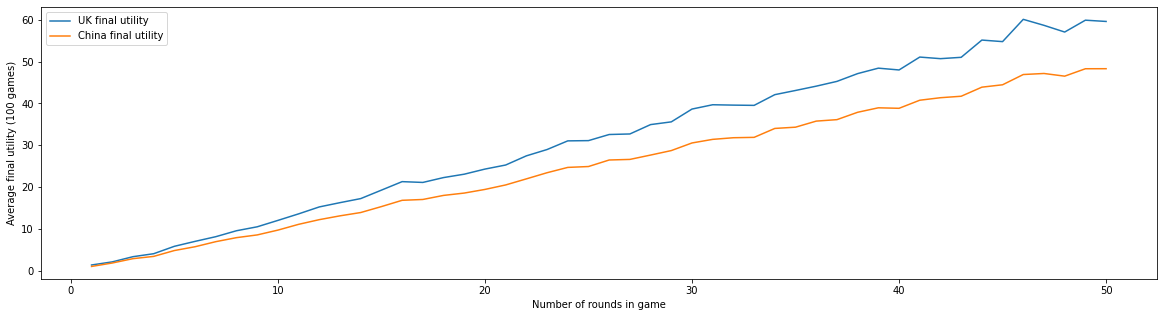

1 avg # coops 0.45 0.52 avg final scores self, opp:  1.39 1.04
2 avg # coops 1.04 0.92 avg final scores self, opp:  2.13 1.86
3 avg # coops 1.46 1.32 avg final scores self, opp:  3.37 2.9
4 avg # coops 1.75 1.78 avg final scores self, opp:  4.08 3.44
5 avg # coops 2.45 2.36 avg final scores self, opp:  5.85 4.84
6 avg # coops 2.78 2.79 avg final scores self, opp:  7.03 5.75
7 avg # coops 3.23 2.96 avg final scores self, opp:  8.15 6.96
8 avg # coops 3.8 3.66 avg final scores self, opp:  9.57 7.92
9 avg # coops 3.98 4.09 avg final scores self, opp:  10.51 8.57
10 avg # coops 4.77 4.82 avg final scores self, opp:  12.04 9.72
11 avg # coops 5.44 5.26 avg final scores self, opp:  13.6 11.1
12 avg # coops 5.83 5.84 avg final scores self, opp:  15.26 12.22
13 avg # coops 6.74 6.55 avg final scores self, opp:  16.28 13.13
14 avg # coops 6.8 6.78 avg final scores self, opp:  17.25 13.92
15 avg # coops 7.82 7.72 avg final scores self, opp:  19.27 15.34
16 avg # coops 8.68 8.48 avg final scores 

In [19]:
# uk plays msne then tft, china plays with msne prob then tit for tat

players = [uk_msne_tft(), china_msne_tft()]

avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores = iterate(50, players)


# plot figure
stats(50, avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores)

In [20]:
msne_tft_scores = avg_self_final_scores

In [21]:
print("UK, China average score for 50 rounds: ", avg_self_final_scores[-1], ",", avg_opponent_final_scores[-1])

UK, China average score for 50 rounds:  59.57 , 48.28


---
## UK plays D-TFT

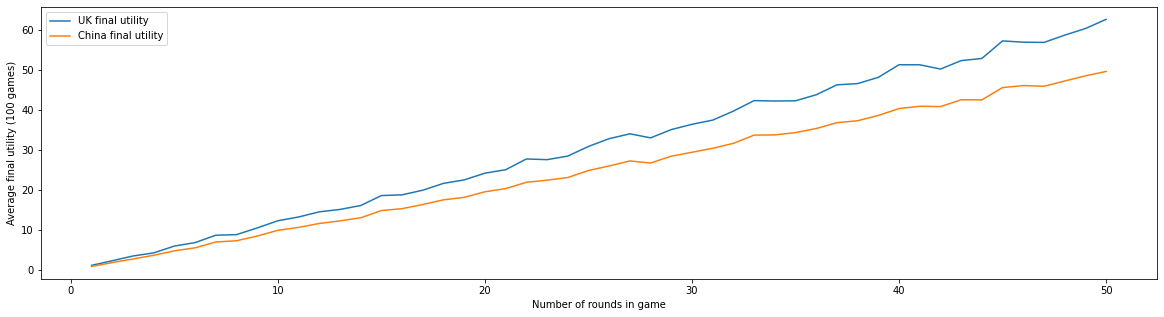

1 avg # coops 0.29 0.43 avg final scores self, opp:  1.1 0.83
2 avg # coops 0.61 0.78 avg final scores self, opp:  2.26 1.8
3 avg # coops 1.06 1.3 avg final scores self, opp:  3.44 2.7
4 avg # coops 1.52 1.54 avg final scores self, opp:  4.22 3.62
5 avg # coops 2.07 2.27 avg final scores self, opp:  5.93 4.73
6 avg # coops 2.36 2.61 avg final scores self, opp:  6.79 5.49
7 avg # coops 2.95 3.11 avg final scores self, opp:  8.64 6.95
8 avg # coops 3.57 3.65 avg final scores self, opp:  8.78 7.25
9 avg # coops 4 4.21 avg final scores self, opp:  10.46 8.43
10 avg # coops 4.67 4.75 avg final scores self, opp:  12.26 9.87
11 avg # coops 4.7 5 avg final scores self, opp:  13.2 10.6
12 avg # coops 5.76 5.92 avg final scores self, opp:  14.49 11.58
13 avg # coops 5.74 5.99 avg final scores self, opp:  15.09 12.23
14 avg # coops 6.3 6.58 avg final scores self, opp:  16.07 13
15 avg # coops 7.12 7.31 avg final scores self, opp:  18.56 14.81
16 avg # coops 7.13 7.29 avg final scores self, opp:  

In [22]:
# uk plays defect then tft, china plays with msne prob then tit for tat

players = [uk_def_tft, china_msne_tft()]

avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores = iterate(50, players)


# plot figure
stats(50, avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores)

In [23]:
def_tft_scores = avg_self_final_scores

In [24]:
print("UK, China average score for 50 rounds: ", avg_self_final_scores[-1], ",", avg_opponent_final_scores[-1])

UK, China average score for 50 rounds:  62.63 , 49.6


---
## UK plays C-TFT

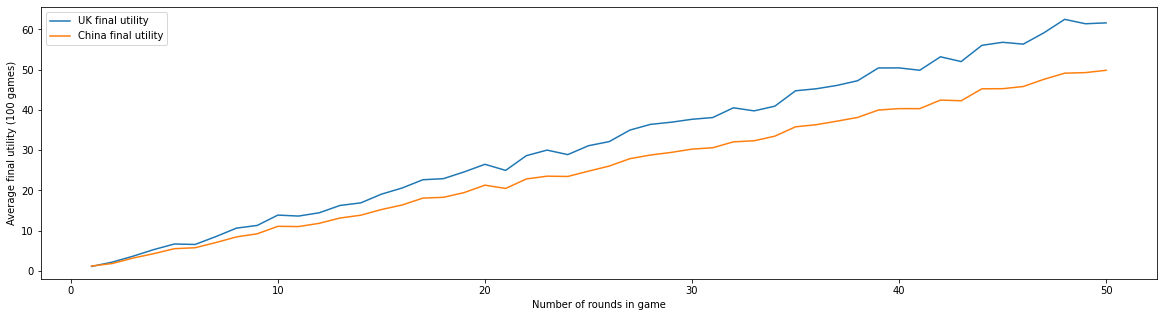

1 avg # coops 0.8 0.4 avg final scores self, opp:  1.1 1.2
2 avg # coops 1.15 1.05 avg final scores self, opp:  2.17 1.83
3 avg # coops 1.82 1.46 avg final scores self, opp:  3.64 3.18
4 avg # coops 2.38 2.17 avg final scores self, opp:  5.28 4.27
5 avg # coops 2.76 2.45 avg final scores self, opp:  6.68 5.51
6 avg # coops 3.07 2.67 avg final scores self, opp:  6.56 5.75
7 avg # coops 3.83 3.53 avg final scores self, opp:  8.51 7.03
8 avg # coops 4.46 4.28 avg final scores self, opp:  10.62 8.44
9 avg # coops 4.85 4.55 avg final scores self, opp:  11.29 9.21
10 avg # coops 5.5 5.17 avg final scores self, opp:  13.86 11.07
11 avg # coops 5.78 5.59 avg final scores self, opp:  13.62 11.01
12 avg # coops 5.75 5.64 avg final scores self, opp:  14.44 11.82
13 avg # coops 7.12 6.79 avg final scores self, opp:  16.26 13.13
14 avg # coops 6.92 6.71 avg final scores self, opp:  16.89 13.83
15 avg # coops 7.88 7.72 avg final scores self, opp:  19.06 15.24
16 avg # coops 8.67 8.47 avg final score

In [25]:
# uk plays cooperate then tit for tat, china plays with msne prob then tit for tat

players = [uk_coop_tft, china_msne_tft()]

avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores = iterate(50, players)


# plot figure
stats(50, avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores)

In [26]:
coop_tft_scores = avg_self_final_scores

In [27]:
print("UK, China average score for 50 rounds: ", avg_self_final_scores[-1], ",", avg_opponent_final_scores[-1])

UK, China average score for 50 rounds:  61.62 , 49.84


---
## UK plays D

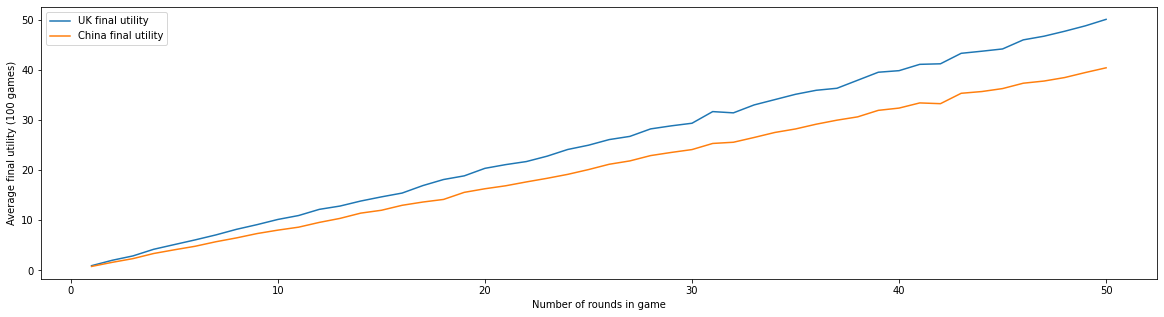

1 avg # coops 0.27 0.35 avg final scores self, opp:  0.94 0.79
2 avg # coops 0.43 0.69 avg final scores self, opp:  2.02 1.61
3 avg # coops 0.59 0.97 avg final scores self, opp:  2.89 2.35
4 avg # coops 0.87 1.35 avg final scores self, opp:  4.21 3.37
5 avg # coops 1.05 1.69 avg final scores self, opp:  5.15 4.11
6 avg # coops 1.3 2.11 avg final scores self, opp:  6.08 4.81
7 avg # coops 1.34 2.23 avg final scores self, opp:  7.07 5.71
8 avg # coops 1.55 2.68 avg final scores self, opp:  8.19 6.48
9 avg # coops 1.82 2.95 avg final scores self, opp:  9.13 7.35
10 avg # coops 1.88 3.33 avg final scores self, opp:  10.16 8.03
11 avg # coops 2.19 3.8 avg final scores self, opp:  10.94 8.62
12 avg # coops 2.29 4.07 avg final scores self, opp:  12.17 9.57
13 avg # coops 2.54 4.21 avg final scores self, opp:  12.83 10.37
14 avg # coops 2.75 4.3 avg final scores self, opp:  13.83 11.42
15 avg # coops 3.22 4.93 avg final scores self, opp:  14.66 11.99
16 avg # coops 3.31 4.84 avg final scores s

In [28]:
# uk plays always defect, china plays with msne prob then tit for tat

players = [uk_def, china_msne_tft()]

avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores = iterate(50, players)


# plot figure
stats(50, avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores)

In [29]:
def_scores = avg_self_final_scores

In [30]:
print("UK, China average score for 50 rounds: ", avg_self_final_scores[-1], ",", avg_opponent_final_scores[-1])

UK, China average score for 50 rounds:  50.05 , 40.39


--- 
## UK plays C

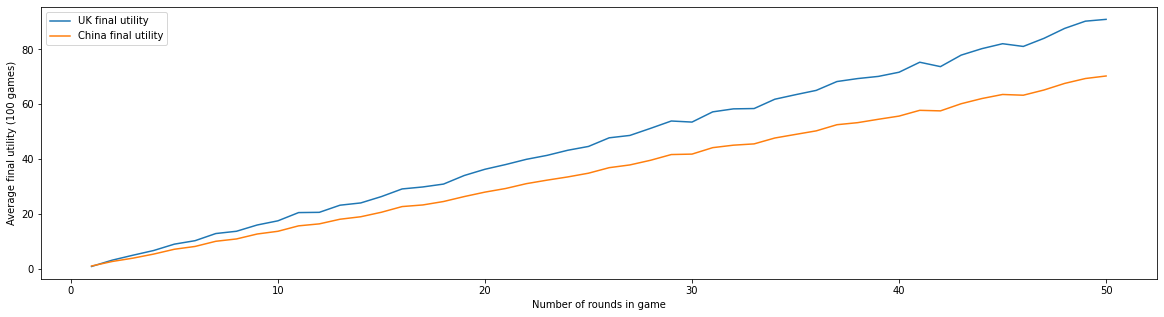

1 avg # coops 0.74 0.35 avg final scores self, opp:  0.95 1.11
2 avg # coops 1.64 1.16 avg final scores self, opp:  3.24 2.76
3 avg # coops 2.28 1.91 avg final scores self, opp:  5.04 3.97
4 avg # coops 3.13 2.47 avg final scores self, opp:  6.75 5.45
5 avg # coops 4.15 3.27 avg final scores self, opp:  9.07 7.21
6 avg # coops 4.73 3.81 avg final scores self, opp:  10.33 8.23
7 avg # coops 5.71 4.65 avg final scores self, opp:  12.93 10.11
8 avg # coops 6.36 5.12 avg final scores self, opp:  13.76 10.96
9 avg # coops 7.36 5.84 avg final scores self, opp:  16.04 12.76
10 avg # coops 7.92 6.57 avg final scores self, opp:  17.56 13.75
11 avg # coops 8.83 7.53 avg final scores self, opp:  20.56 15.73
12 avg # coops 9.62 7.73 avg final scores self, opp:  20.65 16.45
13 avg # coops 10.45 8.66 avg final scores self, opp:  23.25 18.14
14 avg # coops 11.05 9.04 avg final scores self, opp:  24.07 19.04
15 avg # coops 11.83 9.8 avg final scores self, opp:  26.39 20.68
16 avg # coops 12.96 10.67 a

In [31]:
# uk plays always cooperate, china plays with msne prob then tit for tat

players = [uk_coop, china_msne_tft()]

avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores = iterate(50, players)


# plot figure
stats(50, avg_self_coops, avg_opp_coops, avg_self_final_scores, avg_opponent_final_scores)

In [32]:
coop_scores = avg_self_final_scores

In [33]:
print("UK, China average score for 50 rounds: ", avg_self_final_scores[-1], ",", avg_opponent_final_scores[-1])

UK, China average score for 50 rounds:  90.91 , 70.29



---

# Plotting UK payoffs


In [34]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': '9',
          'figure.figsize': (6, 3),
         'axes.labelsize': '9',
         'axes.titlesize':'9',
         'xtick.labelsize':'9',
         'ytick.labelsize':'7'}
pylab.rcParams.update(params)


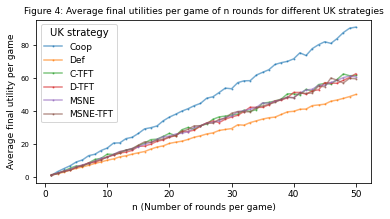

In [36]:
# creating x axis values (# rounds per game)
x = [x for x in range(1,51)] 

# setting marker size on graph
ms = 1

# plot lines
plt.plot(x, coop_scores, label = "Coop", markersize=ms, marker="o", alpha=0.6)
plt.plot(x, def_scores, label = "Def", markersize=ms, marker="o", alpha=0.6)
plt.plot(x, coop_tft_scores, label= "C-TFT", markersize=ms, marker="o", alpha=0.6)
plt.plot(x, def_tft_scores, label = "D-TFT", markersize=ms, marker="o", alpha=0.6)
plt.plot(x, msne_scores, label = "MSNE", markersize=ms, marker="o", alpha=0.6)
plt.plot(x, msne_tft_scores, label = "MSNE-TFT", markersize=ms, marker="o", alpha=0.6)

plt.xlabel("n (Number of rounds per game)")
plt.ylabel("Average final utility per game")
plt.title("Figure 4: Average final utilities per game of n rounds for different UK strategies")
plt.legend(title="UK strategy")

plt.savefig("uk_utils")